In [ ]:
!nvidia-smi

Fri Jan 22 18:25:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    30W /  70W |   7271MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

##Loading data 
در این بخش داده ها لود می شوند و فرآیند نرمال سازی بر روی آن ها صورت می گیرد


In [ ]:
from keras.datasets import fashion_mnist
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()

data that are going to be used in our network must have 3 dimesnitions, therefore x_train should be exapnded 

 داده ورودی به شبکه باید 3 بعد داشته باشد، به همین خاطر یک بعد به ایکس ترین اضافه می کنیم.
اضافه کردن این بعد همانند این است که یک عکس خاکستری داشته باشیم، به جای 3 کانال رنگ تنها 1 کانال رنگ داریم(سیاه و سفید)

In [ ]:
x_train = np.expand_dims(x_train,axis=-1)  #expanding dimesnion
x_test = np.expand_dims(x_test,axis=-1) #expanding dimesnion
x_train=x_train.astype('float32')/255  #Normalization
x_test=x_test.astype('float32')/255 #Normalization

In [ ]:
x_train.shape

(60000, 28, 28, 1)

##Generating Real Data


we should define functions for generating both real and fake data, since these data have to be generated reapetedly in a for loop in the training part of this code 

These Real Data are going to be used for training phase of discriminator.
Output of this part : [x_real,label_real],y 
x_real : gray image matrix- shape : (28,28,1)  
label_real : label which is related to the x_real - label = [0,...9]
y : it would be 1, if data was real and it would be 0 if data was fake. in this part we are producing real data,therefore y==1.

in order to generate real samples, we are going to chose random samples among x_train and y_train 

batch size is 64, in each training epoch half of this amount is dedicated to training of discriminator and othe half is for generator.So 32 random data should be chosen from real data in each epoch.

In [ ]:
batch_size = 64 
h_batch = int (batch_size/2)
def real_data():
  ind = np.random.randint(0,x_train.shape[0],h_batch)
  x_real = x_train[ind]
  label_real = y_train[ind]
  y_real = np.ones((h_batch,1))
  return [x_real,label_real],y_real

## Generating Fake data

generator takes input from a latent space. in conditional-Gan some random classes shoulde also be chosen with random points in the latent space. 

In [ ]:
def fake_data():
  z = np.random.randn(int (batch_size/2),100) # 100 is the latent space size
  label_fake = np.random.randint(0,10,int (batch_size/2))
  y_fake = np.zeros((int (batch_size/2),1))
  return[z,label_fake],y_fake

def fake_data2():
  z = np.random.randn(int (batch_size),100) # 100 is the latent space size
  label_fake = np.random.randint(0,10,int (batch_size))
  y_fake = np.zeros((int (batch_size),1))
  return[z,label_fake],y_fake

# Network architecture :
Netwotk that is going to be used in this question is a cDCGAN which means that discriminator and generator parts have convolutional layers(DCGAN).This network is conditioned on labels as well(Conditional-GAN) 

we will define generatr and discriminator parts seperately and final cDCGAN is going to be combination of these two parts 

In [ ]:
from keras.models import Model,Sequential
from keras.layers import Input,Dense,Conv2D,Flatten,ReLU,Dropout,UpSampling2D,Embedding,Concatenate,Conv2DTranspose
from keras.layers import Reshape,MaxPool2D
from keras.layers import LeakyReLU
from keras.optimizers import Adam,RMSprop

## Generator section
in this part of code we will define architecture of generator model.As mentioned before, there are some convolution layers here. we would use conv2d and upsampling in order to make (28,28,1) images from random points in the latent space. output of this section is going to be fed into discriminator part.
we could consider generator as a Decoder here. 

there is no compile here and weights related to Genereator section would be updated when Final GAN model is being trained. ** in the Final GAN model trainig phase , discriminator weights are freezed.Consequently, Generator weights are only updated 

Final generated image should have a shape of (28,28,1) which is the shape of images in the fashion-MNIST dataset. we are going to use 2 Usampling in this part. As a result the inital shape should be = (28/4 , 28/4,1)=(7,7,1)

for Upsampling part we would use Conv2dTrasnpose() with stirde of (2,2).
**Using Conv2dTranspose() will tend to better results compared to Upsampling2D()

In [ ]:
def generator():
  input_label = Input(shape=(1,))
  c = Embedding(10,20)(input_label)
  c = Dense(7*7)(c)
  c = Reshape((7,7,1))(c)

  z_input = Input(shape=(100,)) # 100 is the latent space size
  z = Dense(7*7*64, activation='relu')(z_input)
  z = Reshape((7,7,64))(z)

  final_input = Concatenate()([z,c])

  generator = Conv2DTranspose(256,(4, 4),activation='relu',strides=(2,2),kernel_initializer='he_uniform',padding='same')(final_input)
  generator = Conv2DTranspose(128, (4,4),activation='relu',strides=(2,2),kernel_initializer='he_uniform',padding='same')(generator)


  output = Conv2D(1,(10,10),activation='tanh',padding='same')(generator)
  
  model = Model([z_input,input_label],output)

  return model

In [ ]:
test = generator()
test.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 20)        200         input_5[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 3136)         316736      input_6[0][0]                    
____________________________________________________________________________________________

## Discriminatro Section
in this part of code we will define architecture of discriminator model.As mentioned before, there are some convolution layers here. we would use conv2d for downsampling of a (28,28,1) image  to understand whether this  image is fake or real. input of this section could be the fake images generated by generator section.However in the trainig phase real images with their labels are going to be fed into this network.we will define "Compile" in this network since we want to update discriminator weights independently.

In [ ]:
def discriminator():
  input_label = Input(shape=(1,))
  c = Embedding(10,20)(input_label)
  c = Dense(28*28)(c)
  c = Reshape((28,28,1))(c)

  z_input = Input(shape=(28,28,1)) # 100 is the latent space size

  final_input = Concatenate()([z_input,c])

  discriminator = Conv2D(32, (4, 4),strides=(2,2),activation='relu',kernel_initializer='he_uniform',  padding='same')(final_input)
  discriminator = Conv2D(64, (4, 4),strides=(2,2),activation='relu',kernel_initializer='he_uniform',  padding='same')(discriminator)
  discriminator = Conv2D(128, (4, 4),strides=(2,2),activation='relu',kernel_initializer='he_uniform',  padding='same')(discriminator)
  discriminator = Conv2D(256, (4, 4),strides=(2,2),activation='relu',kernel_initializer='he_uniform', padding='same')(discriminator)

  

  discriminator = Flatten()(discriminator)
  discriminator = Dropout(0.5)(discriminator)
  output = Dense(1,activation='sigmoid')(discriminator)

  
  model = Model([z_input,input_label],output)
  opt = Adam(lr=1e-4)
  #,beta_1 =0.5
  model.compile(loss='mse', optimizer=opt,metrics=['accuracy'])
  return model

In [ ]:
test2 = discriminator()
test2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 20)        200         input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1, 784)       16464       embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
____________________________________________________________________________________________

## cDCGAN Network
This network is our final model.For building this network, we should use the Generator and the Discriminator Networks together. 
1.   Input of CDCGAN : a random poin form the latent space + random class label (same as the input of the generator part).
2. Genrator produces fake images based on the inputs of CDCGAN Network 
3. The fake generated image with the class label are fed into the Discriminator 
4. Output of the CDCGAN is same as the output of the discriminator.

** important note : As discussed before, Discriminator wieghts are not allowed to be updated while CDCGAN is being trained

In [ ]:
def CDCGAN(generatormodel,discriminatormodel):
  discriminatormodel.trainable = False
  z_input , c_input  = generatormodel.input 
  fake_image = generatormodel.output 
  CDCGAN_output = discriminatormodel([fake_image,c_input])
  finalmodel = Model([z_input , c_input],CDCGAN_output)
  opt = Adam(lr=1e-4)
  finalmodel.compile(loss='mse', optimizer=opt)
  return finalmodel


# Trainig Generator and Discriminator. 
Steps to train our model:


1.   Define model and its architecture : in our case this is a cDCGan and the architecture of this model has been designed in the perivious sections 
2.   Train Discriminatro on real data for n epochs
3.   Generate fake inputs for generator and train Discriminator on fake data.
4.   Train generator with the output of discriminator( discriminator weights are fixed in this stage)




Same procedure is applied in the next section of the code. Hyperparameters are defiend as below :
1.   No of Epochs : 50 
2.   batch size = 64

In [ ]:
generatormodel = generator()
discriminatormodel = discriminator()
CDCGANmodel = CDCGAN(generatormodel,discriminatormodel)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from numpy import asarray
import matplotlib.pyplot as plt

In [ ]:
f_d_fake= []
f_d_real = []
f_g = []
discriminatorloss_fake = []
discriminatorloss_real = []
generatorloss = []
for i in range(51):

  for j in range(int (x_train.shape[0]/batch_size)):
    # real samples-updating discriminator wieghts based on real data-phase1 
    [x_real,label_real] , y_real = real_data()
    discriminator_loss_real,_ = discriminatormodel.train_on_batch([x_real, label_real], y_real)

    # fake samples-updating discriminator wieghts based on real data-phase2
    [z_fake,label_fake] , y_fake = fake_data()
    x_fake = generatormodel.predict([z_fake,label_fake]) #generating fake image as an input to discriminator network
    discriminator_loss_fake,_= discriminatormodel.train_on_batch([x_fake, label_fake], y_fake)
    
    
    #training generator/cdcgan model
    [z_fake,label_fake] , y_fake = fake_data2()
    y_model = np.ones((batch_size,1))
    finalloss = CDCGANmodel.train_on_batch([z_fake, label_fake], y_model)



  print('>%d, d1=%.3f ,d2=%.3f ,g=%.3f' %(i+1,discriminator_loss_real, discriminator_loss_fake, finalloss))
  f_d_fake.append((discriminator_loss_fake))
  f_d_real.append((discriminator_loss_real))
  f_g.append((finalloss))

  """
  if i ==0 or i==20 or i==30 or i==40 or i==50 :
    latent_points = np.random.randn(60,100) # 100 is the latent space size
    label2 = np.zeros([60])
    jjj = 0
    for _ in range(6):
      for mo in range(10):
        label2[jjj] = mo
        jjj+=1
    X  = generatormodel.predict([latent_points, label2])
    plt.figure(figsize=(10,10))
    for ii in range(60):
        # define subplot
        plt.subplot(6, 10, 1 + ii)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(X[ii, :, :, 0], cmap='gray_r')
        #plt.title("Epoch Number ",ii)
    plt.show()
    """


   
generatormodel.save('/content/drive/MyDrive/CDCGANmodell.h5')



>1, d1=0.013 ,d2=0.005 ,g=0.933
>2, d1=0.029 ,d2=0.028 ,g=0.830
>3, d1=0.059 ,d2=0.084 ,g=0.706
>4, d1=0.038 ,d2=0.081 ,g=0.837
>5, d1=0.100 ,d2=0.045 ,g=0.832
>6, d1=0.080 ,d2=0.060 ,g=0.619
>7, d1=0.095 ,d2=0.078 ,g=0.717
>8, d1=0.108 ,d2=0.103 ,g=0.670
>9, d1=0.036 ,d2=0.134 ,g=0.717
>10, d1=0.073 ,d2=0.124 ,g=0.600
>11, d1=0.083 ,d2=0.073 ,g=0.617
>12, d1=0.193 ,d2=0.094 ,g=0.586
>13, d1=0.103 ,d2=0.119 ,g=0.579
>14, d1=0.177 ,d2=0.098 ,g=0.675
>15, d1=0.143 ,d2=0.086 ,g=0.638
>16, d1=0.166 ,d2=0.115 ,g=0.629
>17, d1=0.148 ,d2=0.086 ,g=0.593
>18, d1=0.139 ,d2=0.137 ,g=0.561
>19, d1=0.123 ,d2=0.115 ,g=0.503
>20, d1=0.135 ,d2=0.121 ,g=0.480
>21, d1=0.249 ,d2=0.098 ,g=0.569
>22, d1=0.204 ,d2=0.166 ,g=0.429
>23, d1=0.127 ,d2=0.180 ,g=0.408
>24, d1=0.228 ,d2=0.103 ,g=0.473
>25, d1=0.202 ,d2=0.184 ,g=0.535
>26, d1=0.107 ,d2=0.142 ,g=0.502
>27, d1=0.210 ,d2=0.179 ,g=0.471
>28, d1=0.188 ,d2=0.133 ,g=0.456
>29, d1=0.272 ,d2=0.191 ,g=0.463
>30, d1=0.225 ,d2=0.166 ,g=0.511
>31, d1=0.280 ,d2=0

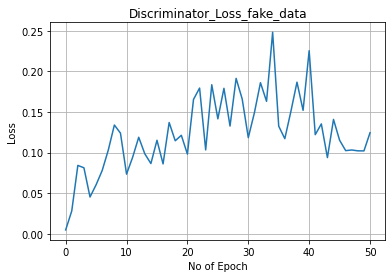

In [ ]:
plt.plot(np.arange(0,51),f_d_fake)
plt.title("Discriminator_Loss_fake_data")
plt.xlabel("No of Epoch")
plt.ylabel("Loss")
plt.grid()

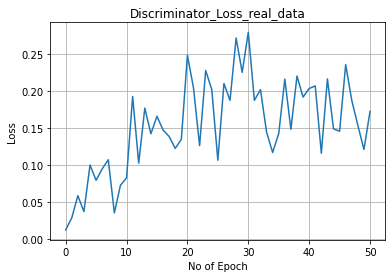

In [ ]:
plt.plot(np.arange(0,51),f_d_real)
plt.title("Discriminator_Loss_real_data")
plt.xlabel("No of Epoch")
plt.ylabel("Loss")
plt.grid()

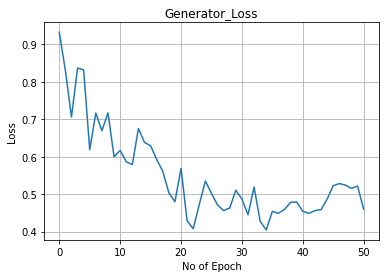

In [ ]:
plt.plot(np.arange(0,51),f_g)
plt.title("Generator_Loss")
plt.xlabel("No of Epoch")
plt.ylabel("Loss")
plt.grid()

In [ ]:
from numpy import asarray
from matplotlib import pyplot
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]


def save_plot(examples, n):
	for i in range(60):
		pyplot.subplot(6, 10, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()


latent_points, _ = generate_latent_points(100, 60)



In [ ]:
label2 = np.zeros([60])
j = 0
for _ in range(6):
  for x in range(10):
    label2[j] = x
    j+=1 

In [ ]:
label2

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 0., 1., 2., 3., 4., 5., 6.,
       7., 8., 9., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 0., 1., 2., 3.,
       4., 5., 6., 7., 8., 9., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 0.,
       1., 2., 3., 4., 5., 6., 7., 8., 9.])

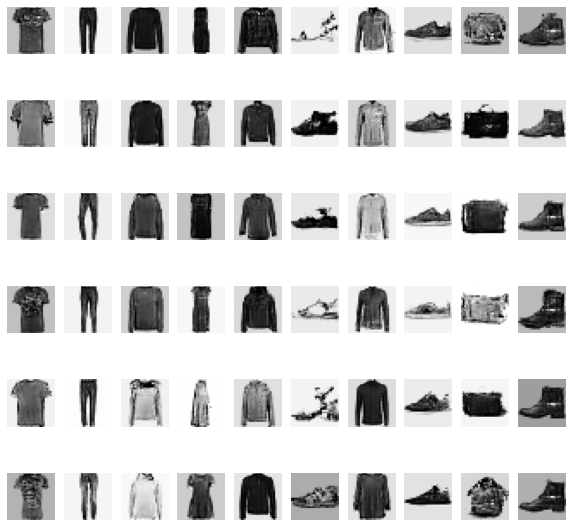

In [ ]:
X  = generatormodel.predict([latent_points, label2])
plt.figure(figsize=(10,10))
for i in range(60):
		pyplot.subplot(6, 10, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
pyplot.show()

# PartB

In [ ]:
def generator():
  input_label = Input(shape=(1,))
  c = Embedding(10,20)(input_label)
  c = Dense(7*7)(c)
  c = Reshape((7,7,1))(c)

  z_input = Input(shape=(100,)) # 100 is the latent space size
  z = Dense(7*7*64, activation='relu')(z_input)
  z = Reshape((7,7,64))(z)

  final_input = Concatenate()([z,c])

  generator = Conv2DTranspose(256,(4, 4),activation='relu',strides=(2,2),kernel_initializer='he_uniform',padding='same')(final_input)
  generator = Conv2DTranspose(128, (4,4),activation='relu',strides=(2,2),kernel_initializer='he_uniform',padding='same')(generator)

  output = Conv2D(1,(10,10),activation='tanh',padding='same')(generator)
  
  model = Model([z_input,input_label],output)

  return model

In [ ]:
def discriminator():
  input_label = Input(shape=(1,))
  c = Embedding(10,20)(input_label)
  c = Dense(28*28)(c)
  c = Reshape((28,28,1))(c)

  z_input = Input(shape=(28,28,1)) # 100 is the latent space size

  final_input = Concatenate()([z_input,c])


  discriminator = Conv2D(32, (4, 4),strides=(2,2),activation='relu',kernel_initializer='he_uniform',  padding='same')(final_input)
  discriminator = Conv2D(64, (4, 4),strides=(2,2),activation='relu',kernel_initializer='he_uniform',  padding='same')(discriminator)
  discriminator = Conv2D(128, (4, 4),strides=(2,2),activation='relu',kernel_initializer='he_uniform',  padding='same')(discriminator)
  discriminator = Conv2D(256, (4, 4),strides=(2,2),activation='relu',kernel_initializer='he_uniform', padding='same')(discriminator)


  discriminator = Flatten()(discriminator)
  discriminator = Dropout(0.5)(discriminator)
  output = Dense(1,activation='sigmoid')(discriminator)

  
  model = Model([z_input,input_label],output)
  #, clipvalue=1.0, decay=6e-8
  opt  = RMSprop(lr=1e-4)

  model.compile(loss='mse', optimizer= opt,metrics=['accuracy'])
  return model

In [ ]:
def CDCGAN(generatormodel,discriminatormodel):
  discriminatormodel.trainable = False
  z_input , c_input  = generatormodel.input 
  fake_image = generatormodel.output 
  CDCGAN_output = discriminatormodel([fake_image,c_input])
  finalmodel = Model([z_input , c_input],CDCGAN_output)
  opt  = RMSprop(lr=1e-4)
  finalmodel.compile(loss='mse', optimizer=opt)
  return finalmodel


In [ ]:
generatormodel = generator()
discriminatormodel = discriminator()
CDCGANmodel = CDCGAN(generatormodel,discriminatormodel)

>1, d1=0.056 ,d2=0.038 ,g=0.859


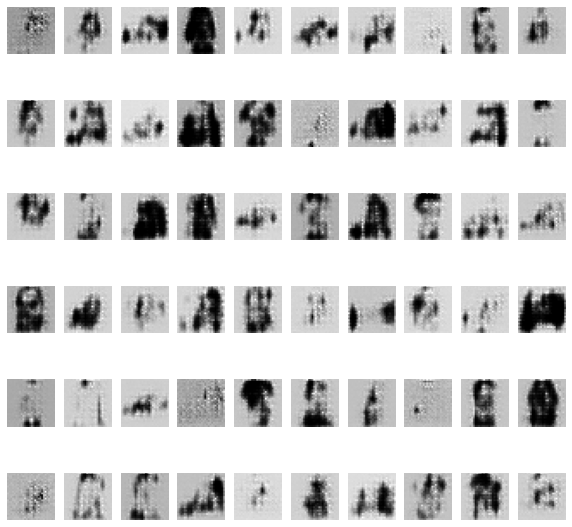

>2, d1=0.027 ,d2=0.008 ,g=0.834
>3, d1=0.057 ,d2=0.024 ,g=0.891
>4, d1=0.064 ,d2=0.019 ,g=0.884
>5, d1=0.060 ,d2=0.048 ,g=0.871
>6, d1=0.073 ,d2=0.096 ,g=0.832
>7, d1=0.162 ,d2=0.054 ,g=0.785
>8, d1=0.118 ,d2=0.075 ,g=0.812
>9, d1=0.079 ,d2=0.058 ,g=0.766
>10, d1=0.046 ,d2=0.052 ,g=0.768
>11, d1=0.101 ,d2=0.099 ,g=0.699
>12, d1=0.150 ,d2=0.139 ,g=0.688
>13, d1=0.121 ,d2=0.099 ,g=0.697
>14, d1=0.207 ,d2=0.121 ,g=0.607
>15, d1=0.145 ,d2=0.110 ,g=0.572
>16, d1=0.184 ,d2=0.124 ,g=0.530
>17, d1=0.167 ,d2=0.169 ,g=0.524
>18, d1=0.213 ,d2=0.144 ,g=0.526
>19, d1=0.192 ,d2=0.212 ,g=0.559
>20, d1=0.205 ,d2=0.150 ,g=0.497
>21, d1=0.233 ,d2=0.162 ,g=0.489


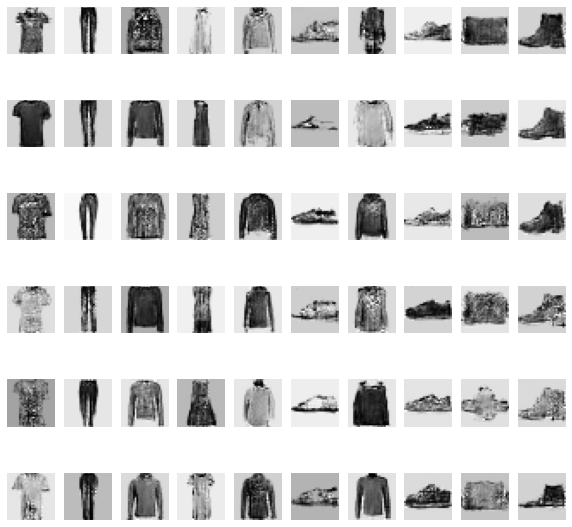

>22, d1=0.193 ,d2=0.247 ,g=0.492
>23, d1=0.170 ,d2=0.177 ,g=0.488
>24, d1=0.234 ,d2=0.188 ,g=0.441
>25, d1=0.208 ,d2=0.125 ,g=0.467
>26, d1=0.146 ,d2=0.127 ,g=0.473
>27, d1=0.228 ,d2=0.141 ,g=0.409
>28, d1=0.295 ,d2=0.136 ,g=0.470
>29, d1=0.264 ,d2=0.138 ,g=0.427
>30, d1=0.232 ,d2=0.148 ,g=0.451
>31, d1=0.205 ,d2=0.160 ,g=0.446


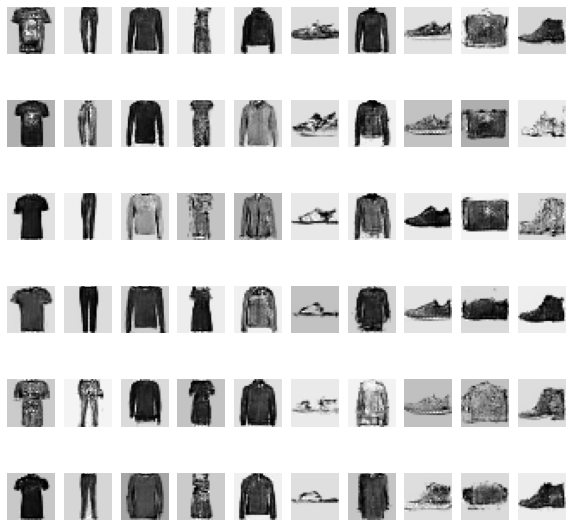

>32, d1=0.186 ,d2=0.194 ,g=0.467
>33, d1=0.165 ,d2=0.142 ,g=0.468
>34, d1=0.145 ,d2=0.192 ,g=0.453
>35, d1=0.137 ,d2=0.193 ,g=0.457
>36, d1=0.231 ,d2=0.180 ,g=0.482
>37, d1=0.174 ,d2=0.143 ,g=0.475
>38, d1=0.177 ,d2=0.135 ,g=0.439
>39, d1=0.189 ,d2=0.157 ,g=0.474
>40, d1=0.199 ,d2=0.134 ,g=0.461
>41, d1=0.168 ,d2=0.134 ,g=0.441


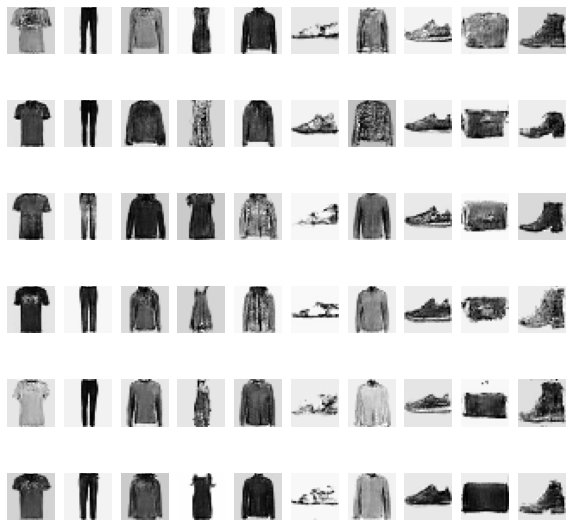

>42, d1=0.228 ,d2=0.160 ,g=0.483
>43, d1=0.199 ,d2=0.165 ,g=0.423
>44, d1=0.161 ,d2=0.263 ,g=0.459
>45, d1=0.193 ,d2=0.131 ,g=0.509
>46, d1=0.206 ,d2=0.169 ,g=0.474
>47, d1=0.201 ,d2=0.181 ,g=0.502
>48, d1=0.163 ,d2=0.177 ,g=0.429
>49, d1=0.202 ,d2=0.174 ,g=0.506
>50, d1=0.197 ,d2=0.135 ,g=0.472
>51, d1=0.256 ,d2=0.147 ,g=0.443


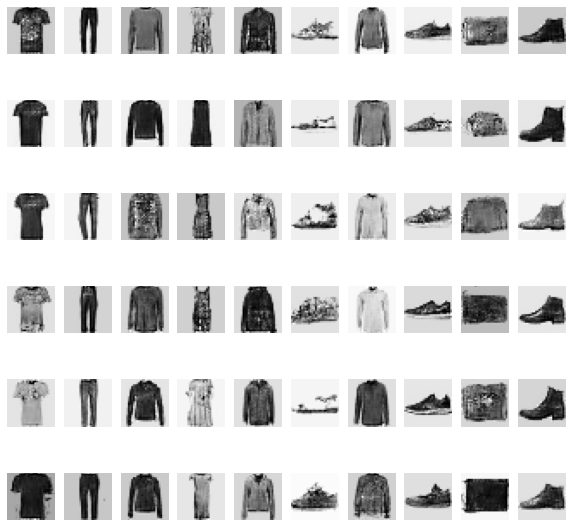

In [ ]:
f_d_fake= []
f_d_real = []
f_g = []
discriminatorloss_fake = []
discriminatorloss_real = []
generatorloss = []
for i in range(51):
  for j in range(int (x_train.shape[0]/batch_size)):
    # real samples-updating discriminator wieghts based on real data-phase1 
    [x_real,label_real] , y_real = real_data()
    discriminator_loss_real,_ = discriminatormodel.train_on_batch([x_real, label_real], y_real)

    # fake samples-updating discriminator wieghts based on real data-phase2
    [z_fake,label_fake] , y_fake = fake_data()
    x_fake = generatormodel.predict([z_fake,label_fake]) #generating fake image as an input to discriminator network
    discriminator_loss_fake,_= discriminatormodel.train_on_batch([x_fake, label_fake], y_fake)
    
    
    #training generator/cdcgan model
    [z_fake,label_fake] , y_fake = fake_data2()
    y_model = np.ones((batch_size,1))
    finalloss = CDCGANmodel.train_on_batch([z_fake, label_fake], y_model)

  print('>%d, d1=%.3f ,d2=%.3f ,g=%.3f' %(i+1,discriminator_loss_real, discriminator_loss_fake, finalloss))
  f_d_fake.append((discriminator_loss_fake))
  f_d_real.append((discriminator_loss_real))
  f_g.append((finalloss))

  
  if  i ==0 or i==20 or i==30 or i==40 or i==50 :
    latent_points = np.random.randn(60,100) # 100 is the latent space size
    label2 = np.zeros([60])
    jjj = 0
    for _ in range(6):
      for mo in range(10):
        label2[jjj] = mo
        jjj+=1
    X  = generatormodel.predict([latent_points, label2])
    plt.figure(figsize=(10,10))
    for ii in range(60):
        plt.subplot(6, 10, 1 + ii)
        plt.axis('off')
        plt.imshow(X[ii, :, :, 0], cmap='gray_r')
    plt.show()
    


   
generatormodel.save('/content/drive/MyDrive/CDCGANmodell_partb.h5')

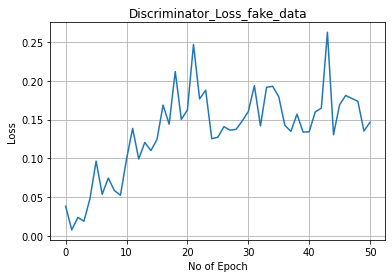

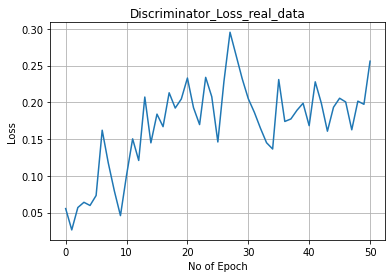

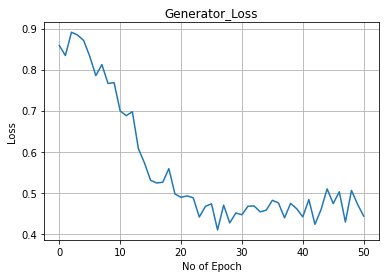

In [ ]:
plt.plot(np.arange(0,51),f_d_fake)
plt.title("Discriminator_Loss_fake_data")
plt.xlabel("No of Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

plt.plot(np.arange(0,51),f_d_real)
plt.title("Discriminator_Loss_real_data")
plt.xlabel("No of Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

plt.plot(np.arange(0,51),f_g)
plt.title("Generator_Loss")
plt.xlabel("No of Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

# part C

In [ ]:
def generator():
  input_label = Input(shape=(1,))
  c = Embedding(10,20)(input_label)
  c = Dense(7*7)(c)
  c = Reshape((7,7,1))(c)

  z_input = Input(shape=(100,)) # 100 is the latent space size
  z = Dense(7*7*64, activation='relu')(z_input)
  z = Reshape((7,7,64))(z)

  final_input = Concatenate()([z,c])

  generator = Conv2DTranspose(256,(4, 4),activation='relu',strides=(2,2),kernel_initializer='he_uniform',padding='same')(final_input)
  generator = Conv2DTranspose(128, (4,4),activation='relu',strides=(2,2),kernel_initializer='he_uniform',padding='same')(generator)

  output = Conv2D(1,(10,10),activation='tanh',padding='same')(generator)
  
  model = Model([z_input,input_label],output)

  return model

In [ ]:
def discriminator():
  input_label = Input(shape=(1,))
  c = Embedding(10,20)(input_label)
  c = Dense(28*28)(c)
  c = Reshape((28,28,1))(c)

  z_input = Input(shape=(28,28,1)) # 100 is the latent space size

  final_input = Concatenate()([z_input,c])


  discriminator = Conv2D(32, (4, 4),strides=(2,2),activation='relu',kernel_initializer='he_uniform',  padding='same')(final_input)
  discriminator = Conv2D(64, (4, 4),strides=(2,2),activation='relu',kernel_initializer='he_uniform',  padding='same')(discriminator)
  discriminator = Conv2D(128, (4, 4),strides=(2,2),activation='relu',kernel_initializer='he_uniform',  padding='same')(discriminator)
  discriminator = Conv2D(256, (4, 4),strides=(2,2),activation='relu',kernel_initializer='he_uniform', padding='same')(discriminator)


  discriminator = Flatten()(discriminator)
  discriminator = Dropout(0.5)(discriminator)
  output = Dense(1,activation='sigmoid')(discriminator)

  
  model = Model([z_input,input_label],output)
  opt  = Adam(lr=1e-4)

  model.compile(loss='binary_crossentropy', optimizer= opt,metrics=['accuracy'])
  return model

In [ ]:
def CDCGAN(generatormodel,discriminatormodel):
  discriminatormodel.trainable = False
  z_input , c_input  = generatormodel.input 
  fake_image = generatormodel.output 
  CDCGAN_output = discriminatormodel([fake_image,c_input])
  finalmodel = Model([z_input , c_input],CDCGAN_output)
  opt  = Adam(lr=1e-4)
  finalmodel.compile(loss='binary_crossentropy', optimizer=opt)
  return finalmodel


In [ ]:
generatormodel = generator()
discriminatormodel = discriminator()
CDCGANmodel = CDCGAN(generatormodel,discriminatormodel)

>1, d1=0.029 ,d2=0.061 ,g=3.463


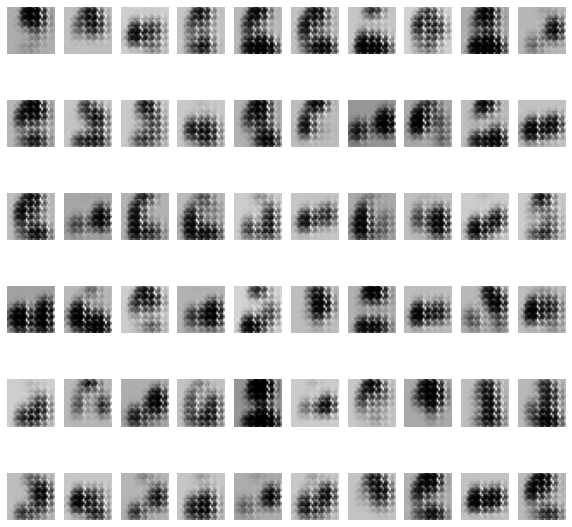

>2, d1=0.158 ,d2=0.072 ,g=3.863
>3, d1=0.125 ,d2=0.152 ,g=3.230
>4, d1=0.314 ,d2=0.112 ,g=2.528
>5, d1=0.451 ,d2=0.153 ,g=2.753
>6, d1=0.263 ,d2=0.190 ,g=1.996
>7, d1=0.664 ,d2=0.246 ,g=2.001
>8, d1=0.133 ,d2=0.256 ,g=2.084
>9, d1=0.271 ,d2=0.223 ,g=1.881
>10, d1=0.259 ,d2=0.264 ,g=1.906
>11, d1=0.231 ,d2=0.293 ,g=1.483
>12, d1=0.455 ,d2=0.198 ,g=1.755
>13, d1=0.523 ,d2=0.608 ,g=1.613
>14, d1=0.382 ,d2=0.387 ,g=1.352
>15, d1=0.585 ,d2=0.396 ,g=1.482
>16, d1=0.587 ,d2=0.402 ,g=1.275
>17, d1=0.407 ,d2=0.471 ,g=1.175
>18, d1=0.546 ,d2=0.406 ,g=1.045
>19, d1=0.574 ,d2=0.578 ,g=1.229
>20, d1=0.609 ,d2=0.497 ,g=1.122
>21, d1=0.493 ,d2=0.412 ,g=1.239


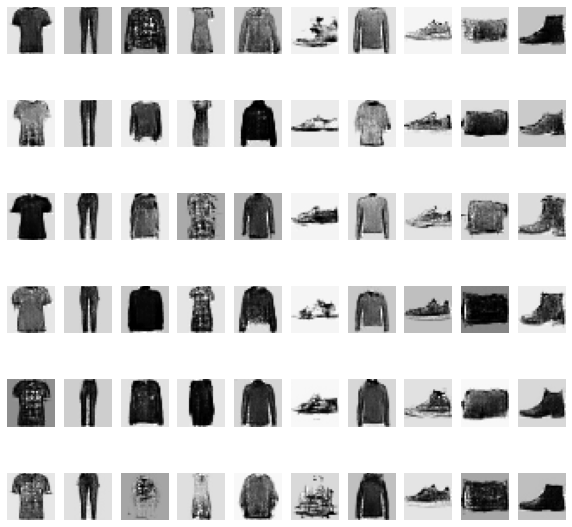

>22, d1=0.568 ,d2=0.484 ,g=1.075
>23, d1=0.626 ,d2=0.700 ,g=0.978
>24, d1=0.519 ,d2=0.571 ,g=1.057
>25, d1=0.487 ,d2=0.468 ,g=1.192
>26, d1=0.473 ,d2=0.453 ,g=1.134
>27, d1=0.577 ,d2=0.505 ,g=1.157
>28, d1=0.602 ,d2=0.489 ,g=1.266
>29, d1=0.618 ,d2=0.417 ,g=1.122
>30, d1=0.565 ,d2=0.523 ,g=1.043
>31, d1=0.501 ,d2=0.361 ,g=1.325


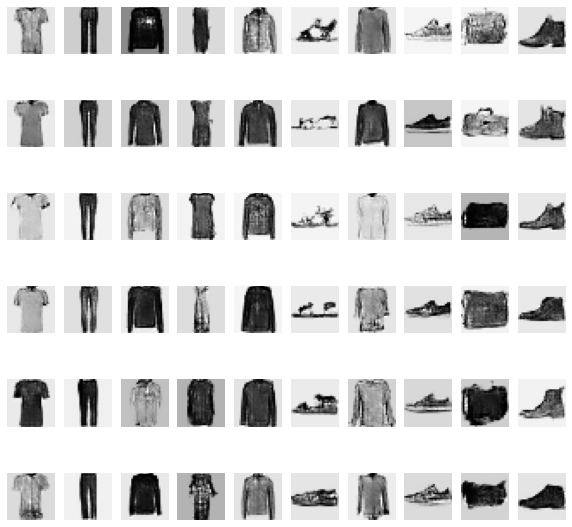

>32, d1=0.480 ,d2=0.532 ,g=1.113
>33, d1=0.466 ,d2=0.646 ,g=1.038
>34, d1=0.442 ,d2=0.429 ,g=1.181
>35, d1=0.384 ,d2=0.432 ,g=1.202
>36, d1=0.563 ,d2=0.560 ,g=1.189
>37, d1=0.523 ,d2=0.523 ,g=0.973
>38, d1=0.401 ,d2=0.421 ,g=0.956
>39, d1=0.683 ,d2=0.367 ,g=1.237
>40, d1=0.720 ,d2=0.435 ,g=1.271
>41, d1=0.480 ,d2=0.736 ,g=1.044


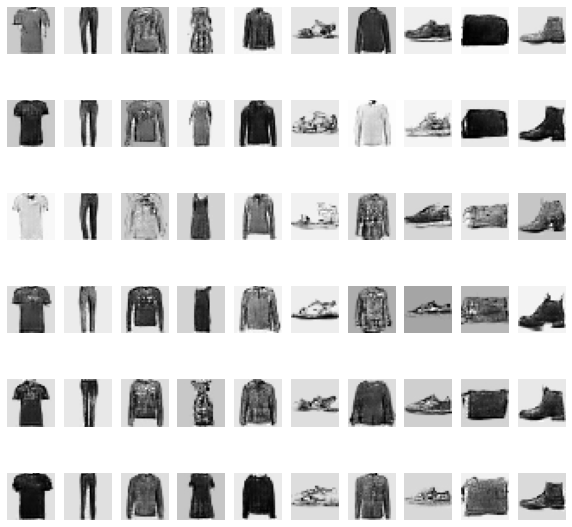

>42, d1=0.599 ,d2=0.486 ,g=1.087
>43, d1=0.577 ,d2=0.404 ,g=1.174
>44, d1=0.591 ,d2=0.628 ,g=1.186
>45, d1=0.573 ,d2=0.478 ,g=1.159
>46, d1=0.548 ,d2=0.472 ,g=1.157
>47, d1=0.595 ,d2=0.639 ,g=1.053
>48, d1=0.539 ,d2=0.475 ,g=1.174
>49, d1=0.467 ,d2=0.391 ,g=1.236
>50, d1=0.685 ,d2=0.516 ,g=1.246
>51, d1=0.380 ,d2=0.380 ,g=1.223


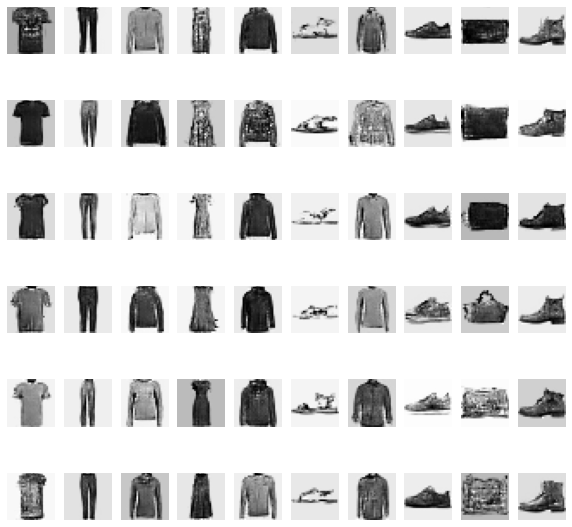

In [ ]:
f_d_fake= []
f_d_real = []
f_g = []
discriminatorloss_fake = []
discriminatorloss_real = []
generatorloss = []
for i in range(51):
  for j in range(int (x_train.shape[0]/batch_size)):
    # real samples-updating discriminator wieghts based on real data-phase1 
    [x_real,label_real] , y_real = real_data()
    discriminator_loss_real,_ = discriminatormodel.train_on_batch([x_real, label_real], y_real)

    # fake samples-updating discriminator wieghts based on real data-phase2
    [z_fake,label_fake] , y_fake = fake_data()
    x_fake = generatormodel.predict([z_fake,label_fake]) #generating fake image as an input to discriminator network
    discriminator_loss_fake,_= discriminatormodel.train_on_batch([x_fake, label_fake], y_fake)
    
    
    #training generator/cdcgan model
    [z_fake,label_fake] , y_fake = fake_data2()
    y_model = np.ones((batch_size,1))
    finalloss = CDCGANmodel.train_on_batch([z_fake, label_fake], y_model)

  print('>%d, d1=%.3f ,d2=%.3f ,g=%.3f' %(i+1,discriminator_loss_real, discriminator_loss_fake, finalloss))
  f_d_fake.append((discriminator_loss_fake))
  f_d_real.append((discriminator_loss_real))
  f_g.append((finalloss))

  
  if  i ==0 or i==20 or i==30 or i==40 or i==50 :
    latent_points = np.random.randn(60,100) # 100 is the latent space size
    label2 = np.zeros([60])
    jjj = 0
    for _ in range(6):
      for mo in range(10):
        label2[jjj] = mo
        jjj+=1
    X  = generatormodel.predict([latent_points, label2])
    plt.figure(figsize=(10,10))
    for ii in range(60):
        plt.subplot(6, 10, 1 + ii)
        plt.axis('off')
        plt.imshow(X[ii, :, :, 0], cmap='gray_r')
    plt.show()
    


   
generatormodel.save('/content/drive/MyDrive/CDCGANmodell_partc.h5')

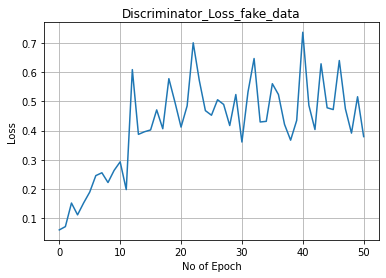

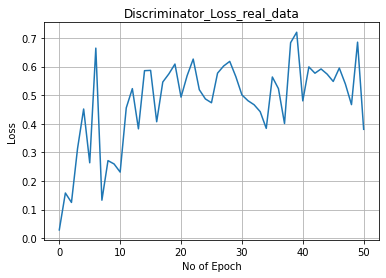

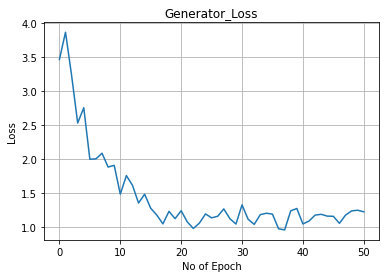

In [ ]:
plt.plot(np.arange(0,51),f_d_fake)
plt.title("Discriminator_Loss_fake_data")
plt.xlabel("No of Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

plt.plot(np.arange(0,51),f_d_real)
plt.title("Discriminator_Loss_real_data")
plt.xlabel("No of Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

plt.plot(np.arange(0,51),f_g)
plt.title("Generator_Loss")
plt.xlabel("No of Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()